What follows is a breakdown on what I have done to build our model, from the yelp dataset, through data cleaning, feature generation, and classifying...

In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.rrule import rrule, MONTHLY
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output, display
import sklearn as skl
%matplotlib inline
pd.options.display.max_rows = 1000

In [2]:
def to_datetime(review_df):
    return review_df.assign(datetime = pd.to_datetime(review_df['date'])).drop(labels=['date'], axis = 'columns').set_index('datetime').sort_index()


Step 1: Building the Dataset

WARNING Don't try to run this on your laptop! The datasets I'm importing are LARGE

In [3]:
#if you want to rebuild the everything, set this to true, but it will take long time much wait
rebuild_dset = False
state = 'AZ'

In [4]:
#load review data and business data
if(rebuild_dset == True):
    reviews = pd.read_json('dataset/yelp_academic_dataset_review.json', lines=True)
    businesses = pd.read_json('dataset/yelp_academic_dataset_business.json', lines=True)
    

In [5]:
#join the two datasets, dropping duplicate/useless labels
if(rebuild_dset == True):
    reviews_businesses = reviews.merge(businesses, on='business_id')
    state_reviews_businesses = reviews_businesses[reviews_businesses['state']==state]
    state_badname  = state_reviews_businesses[['date', 'business_id','user_id', 'name', 'cool', 'funny','useful','review_id', 'stars_x', 'categories','review_count', 'stars_y']]
    state_reviews = state_badname.rename(index=str, columns={'stars_x':'stars_review','stars_y':'stars_avg'})
    state_reviews.to_csv('b2data/' + state + '_data_dirty.csv')
else:
    state_reviews = pd.read_csv('b2data/' + state + '_data_dirty.csv')

In [6]:
#build our inclusive feature list, courtesy of Christina
if(rebuild_dset == True):
    incl_list = ['Asian Fusion','Buffets','Caribbean','Chinese','Trinidadian','Vegetarian','Afghan','African','Arabian','Argentine','Armenian','Australian','Austrian','Bangladeshi','Basque','Bavarian','Brasseries','British','Bulgarian','Burmese','Cambodian','Cantonese','Chilean','Colombian','Cuban','Czech','Czech/Slovakian','Dominican','Donairs','Eastern European','Egyptian','Ethiopian','Falafel','Filipino','Greek','Hainan','Haitian','Hakka','Halal','Hawaiian','Honduran','Hot Pot','Iberian','Indonesian','International','Irish','Irish Pub','Izakaya','Japanese Curry','Kebab','Kosher','Laotian','Lebanese','Malaysian','Mauritius','Mediterranean','Modern European','Mongolian','Moroccan','New Mexican Cuisine','Noodles','Northern German','Pan Asian','Peruvian','Polish','Puerto Rican','Ramen','Russian','Salvadoran','Scandinavian','Scottish','Senegalese','Shanghainese','Sicilian','Singaporean','Slovakian','Soul Food','South African','Spanish','Sri Lankan','Swiss Food','Syrian','Szechuan','Teppanyaki','Traditional Norwegian','Turkish','Tuscan','Ukrainian','Uzbek','Venezuelan','Acai Bowls','American (New)','American (Traditional)','Bagels','Baguettes','Bakeries','Barbeque','Bars','Bartenders','Beach Bars','Beer','Beer Bar','Beer Garden','Beer Gardens','Beer Hall','Beer Tours','Belgian','Bistros','Brazilian','Breakfast & Brunch','Breweries','Brewpubs','Bubble Tea','Burgers','Butcher','Cafes','Cafeteria','Cajun/Creole','Canadian (New)','Candy Stores','Caterers','Champagne Bars','Cheese Shops','Cheesesteaks','Chicken Shop','Chicken Wings','Chocolatiers & Shops','Churros','Cideries','Cocktail Bars','Coffee & Tea','Coffee Roasteries','Coffeeshops','Comfort Food','Creperies','Cupcakes','Custom Cakes','Dance Clubs','Delicatessen','Delis','Desserts','Dim Sum','Diners','Distilleries','Dive Bars','Do-It-Yourself Food','Donuts','Drive-Thru Bars','Empanadas','Ethical Grocery','Ethnic Food','Ethnic Grocery','Fast Food','Fish & Chips','Fishmonger','Fondue','Food','Food Court','Food Stands','Food Trucks','French','Fruits & Veggies','Gastropubs','Gelato','German','Gluten-Free','Honey','Hong Kong Style Cafe','Hot Dogs','Hotel bar','Hungarian','Ice Cream & Frozen Yogurt','Imported Food','Indian','International Grocery','Italian','Japanese','Japanese Sweets','Juice Bars & Smoothies','Karaoke','Kombucha','Korean','Latin American','Live/Raw Food','Local Flavor','Lounges','Macarons','Mexican','Middle Eastern','Milkshake Bars','Minho','Olive Oil','Organic Stores','Pakistani','Palatine','Pasta Shops','Patisserie/Cake Shop','Persian/Iranian','Pita','Pizza','Poke','Pop-Up Restaurants','Popcorn Shops','Poutineries','Pretzels','Pub Food','Pubs','Restaurants','Rotisserie Chicken','Salad','Sandwiches','Seafood','Serbo Croatian','Shaved Ice','Shaved Snow','Smokehouse','Soba','Soup','Southern','Speakeasies','Specialty Food','Sports Bars','Steakhouses','Street Vendors','Sugar Shacks','Supper Clubs','Sushi Bars','Tacos','Taiwanese','Tapas Bars','Tapas/Small Plates','Tea Rooms','Tempura','Thai','Themed Cafes','Tiki Bars','Tonkatsu','Udon','Vegan','Vietnamese','Waffles','Whiskey Bars','Wine & Spirits','Wine Bars','Wraps']
    res_filter = (state_reviews['categories'].str.contains('There is absolutely no way this string is contained'))
    for i, word in enumerate(incl_list):
        clear_output(wait=True)
        print('{:2.2f}% \t'.format(100*i/len(incl_list))+word)
        res_filter = (res_filter | state_reviews['categories'].str.contains(word))
    res_filter.to_csv('b2data/res_filter.csv')
else:
    res_filter = pd.Series.from_csv('b2data/res_filter.csv')

In [7]:
#dropnans and apply filter
if(rebuild_dset == True):
    state_reviews_nona = state_reviews.dropna()
    state_reviews_res = state_reviews_nona[res_filter]
    state_reviews_res.to_csv('b2data/' + state + '_data_clean.csv')
else:
    state_reviews_res = pd.read_csv('b2data/' + state +'_data_clean.csv')

Step 2: Building features

In [8]:
#again, this will take a long time if true
rebuild_features = False

In [9]:
#convert indexes to datetime and sort all reviews by business id, year, and month
state_reviews_dt = to_datetime(state_reviews_res)
state_businesses_grouped = state_reviews_dt.groupby([state_reviews_dt['business_id'], state_reviews_dt.index.year.rename('year'), state_reviews_dt.index.month.rename('month')])

target - monthly growth feature construction

In [10]:
#count reviews per month
rev_per_month = state_businesses_grouped['name'].count()
#change of growth into next month
growth_per_month = -rev_per_month.diff(periods=-1).fillna(0)

#define a mapping function to get growth for each row given business id and date:
def get_growth(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    growth = growth_per_month[bid][date.year][date.month]
    print(date)
    return growth

if rebuild_features == True:
    state_reviews_mg = state_reviews_dt.apply(lambda row: get_growth(row['business_id'], row.name), axis=1)
    clear_output(wait=False)
    state_reviews_mg_df = state_reviews_mg.to_frame()
    state_reviews_mg_df.columns = ['monthly_growth']
    state_reviews_mg_df.to_csv('b2data/' + state+'_monthly_growth.csv')
else:
    state_reviews_mg = to_datetime(pd.read_csv('b2data/' + state+'_monthly_growth.csv').rename(index=str, columns={'datetime':'date'}))


feature: weighted review count

In [11]:
if rebuild_features == True:
    weighted_reviews = ((state_reviews_dt[['funny', 'cool', 'useful']].sum(axis=1)*.05) + 1).to_frame()
    weighted_reviews['business_id'] = state_reviews_dt['business_id']
    weighted_reviews['date'] = state_reviews_dt.index
    weighted_reviews = to_datetime(weighted_reviews.rename(index = str, columns = {0:'weighted_review'}))
    weighted_reviews_grouped = weighted_reviews.groupby([weighted_reviews['business_id'], weighted_reviews.index.year.rename('year'), weighted_reviews.index.month.rename('month')])
    weight_growth = weighted_reviews_grouped['weighted_review'].mean()

def weight_growth_apply(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    #compares to LAST month to prevent leakage
    growth = weight_growth[bid].diff().fillna(0)[date.year][date.month]
    print(date)
    return growth

if rebuild_features == True:
    state_reviews_wg = state_reviews_dt.apply(lambda row: weight_growth_apply(row['business_id'], row.name), axis=1)
    clear_output(wait=False)
    state_reviews_wg_df = state_reviews_wg.to_frame()
    state_reviews_wg_df.columns = ['weight_growth']
    state_reviews_wg_df.to_csv('b2data/' + state + '_weight_growth.csv')
else:
    state_reviews_wg = to_datetime(pd.read_csv('b2data/' + state + '_weight_growth.csv').rename(index=str, columns={'datetime':'date'}))


feature: stars growth(from previous month)

In [12]:
#computes average star rating in reviews per month (and business id)
avg_stars_per_month = state_businesses_grouped['stars_review'].mean()

def get_star_growth(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    #compares to LAST month to prevent leakage
    growth = avg_stars_per_month[bid].diff().fillna(0)[date.year][date.month]
    print(date)
    return growth

if rebuild_features == True:
    state_reviews_sg = state_reviews_dt.apply(lambda row: get_star_growth(row['business_id'], row.name), axis=1)
    clear_output(wait=False)
    state_reviews_sg_df = state_reviews_sg.to_frame()
    state_reviews_sg_df.columns = ['star_growth']
    state_reviews_sg_df.to_csv('b2data/' + state + '_star_growth.csv')
else:
    state_reviews_sg = to_datetime(pd.read_csv('b2data/' + state + '_star_growth.csv').rename(index=str, columns={'datetime':'date'}))


feature: % review growth

In [13]:
def get_percent_reviews(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    revs = rev_per_month[bid][date.year][date.month]
    r_count = rev_per_month[bid].cumsum()[date.year][date.month]
    print(timestamp)
    rev_percent = revs/r_count
    return rev_percent

if rebuild_features == True:
    state_reviews_percent = state_reviews_dt.apply(lambda row: get_percent_reviews(row['business_id'], row.name), axis=1)
    clear_output(wait=False)
    state_reviews_percent_df = state_reviews_percent.to_frame()
    state_reviews_percent_df.columns = ['percent_reviews']
    state_reviews_percent_df.to_csv('b2data/' + state + '_percent_reviews.csv')
else:
    state_reviews_percent = to_datetime(pd.read_csv('b2data/' + state + '_percent_reviews.csv').rename(index=str, columns={'datetime':'date'}))

feature: trendiness

In [14]:
#functions

def get_categories(review_df):
    listed_cats = review_df['categories'].str.split(', ').dropna()
    flat_list = [item for sublist in listed_cats.values for item in sublist]
    return flat_list

#return a list of categories for a specific business (takes either a single row or full dataframe witha businessid)
def get_categories_business(business_df, business_id = None):
    if business_id!=None:
        categories = business_df[business_df['business_id'] == business_id].iloc[0]['categories']
    else:
        categories = business_df['categories']
    listed_cats = categories.split(', ')
    return listed_cats

#finds the N most popular categories for a given year and month
def top_categories_date(reviews, year, month, N=15, stopwords = []):
    if type(reviews.index[0]) == pd._libs.tslib.Timestamp:
        review_dt = reviews
    else:
        review_dt = to_datetime(reviews)
    time_filter = ((state_reviews_dt.index.year == year) & (state_reviews_dt.index.month == month))
    time_reviews = review_dt[time_filter]
    flat_list = get_categories(time_reviews)
    counted_categories = Counter(flat_list)
    sorted_categories = list(OrderedDict(counted_categories.most_common()).keys())
    for word in stopwords:
        if(word in sorted_categories):
            sorted_categories.remove(word)
    return sorted_categories[:N]

#computes number of categories in commmon with a business and a given month
def trendiness_measure(review_df, year, month, business_id, N = 15):
    business_cats = get_categories_business(review_df, business_id = business_id)
    trendiness_cats = top_categories_date(review_df, year, month, N=N)
    return len(set(business_cats) & set(trendiness_cats))

In [15]:
#build monthly trendiness array
time_grouped = state_reviews_dt.groupby([state_reviews_dt.index.year.rename('year'), state_reviews_dt.index.month.rename('month')])
if rebuild_features == True:
    months = []
    for key in time_grouped.groups.keys():
        months.append(datetime.date(key[0],key[1], 1))

    top_categories = pd.DataFrame(index = months, columns = {"top_categories":''})
    for i, date in enumerate(months):
        print('{:2.4f}% complete\t'.format(i*100/len(months)) + str(date))
        top_categories.loc[date]['top_categories'] = ', '.join(top_categories_date(state_reviews_dt, date.year, date.month, N=100))
    top_categories.to_csv('b2data/' + state + '_monthly_trends.csv')
else:  
    top_categories = to_datetime(pd.read_csv('b2data/' + state + '_monthly_trends.csv').head().rename(index = str, columns = {'Unnamed: 0':'date'}))

In [16]:
def trendiness_measure_apply(categories, timestamp):
    if type(categories)==float:
        return 0
    business_cats = categories.split(', ')
    date = datetime.date(timestamp.year, timestamp.month, 1)
    print(date)
    trendiness_cats = top_categories.loc[date]['top_categories'].split(', ')
    result = len(set(business_cats) & set(trendiness_cats))
    return result

if rebuild_features == True:
    state_trendiness = state_reviews_dt.apply(lambda row: trendiness_measure_apply(row['categories'], row.name), axis=1)
    clear_output(wait=False)
    state_trendiness_df = state_trendiness.to_frame()
    state_trendiness_df.columns = ['trendiness']
    state_trendiness.to_csv('b2data/' + state + '_trendiness.csv')
else:
    state_trendiness = to_datetime(pd.read_csv('b2data/' + state + '_trendiness.csv').rename(index=str, columns={'datetime':'date'}))


Step 3: Modeling

In [17]:
#make a big dataframe:
state_reviews_dt['trendiness'] = state_trendiness
state_reviews_dt['monthly_growth'] = state_reviews_mg
state_reviews_dt['percent_reviews'] = state_reviews_percent
state_reviews_dt['star_growth'] = state_reviews_sg
state_reviews_dt['weight_growth'] = state_reviews_wg

In [18]:
#set target threshold
state_reviews_dt['high_growth'] = (state_reviews_dt['monthly_growth']>3)

In [19]:
state_reviews_dt.to_csv('b2data/' + state + '_all_features.csv')

In [40]:
#train/test split
from sklearn.model_selection import train_test_split
X = state_reviews_dt[['trendiness', 'percent_reviews', 'star_growth', 'weight_growth']]
Y = state_reviews_dt['high_growth']
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [30]:
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

print("Training Decision Tree...")
dtc = DecisionTreeClassifier()
dtc.fit(Xtr, Ytr)

print("Training Logistic Regression...")
lrc = LogisticRegression()
lrc.fit(Xtr, Ytr)

print("Training Bernoulli Naive Bayes...")
nbc = BernoulliNB()
nbc.fit(Xtr, Ytr)

print("Training Random Forest...")
rfc = RandomForestClassifier()
rfc.fit(Xtr, Ytr)

print("Decision Tree mean accuracy: {:2.4f}".format(dtc.score(Xte,Yte)))
print("Log-Reg mean accuracy: {:2.4f}".format(lrc.score(Xte,Yte)))
print("Naïve Bayes mean accuracy: {:2.4f}".format(nbc.score(Xte,Yte)))
print("Random Forest mean accuracy: {:2.4f}".format(rfc.score(Xte,Yte)))
print('Base accuracy: {:2.4f}'.format(1-Yte.sum()/Yte.count()))
'''

'\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.naive_bayes import BernoulliNB\nfrom sklearn.ensemble import RandomForestClassifier\n\nprint("Training Decision Tree...")\ndtc = DecisionTreeClassifier()\ndtc.fit(Xtr, Ytr)\n\nprint("Training Logistic Regression...")\nlrc = LogisticRegression()\nlrc.fit(Xtr, Ytr)\n\nprint("Training Bernoulli Naive Bayes...")\nnbc = BernoulliNB()\nnbc.fit(Xtr, Ytr)\n\nprint("Training Random Forest...")\nrfc = RandomForestClassifier()\nrfc.fit(Xtr, Ytr)\n\nprint("Decision Tree mean accuracy: {:2.4f}".format(dtc.score(Xte,Yte)))\nprint("Log-Reg mean accuracy: {:2.4f}".format(lrc.score(Xte,Yte)))\nprint("Naïve Bayes mean accuracy: {:2.4f}".format(nbc.score(Xte,Yte)))\nprint("Random Forest mean accuracy: {:2.4f}".format(rfc.score(Xte,Yte)))\nprint(\'Base accuracy: {:2.4f}\'.format(1-Yte.sum()/Yte.count()))\n'

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC



In [24]:
classifiers = [DecisionTreeClassifier, LogisticRegression, BernoulliNB, RandomForestClassifier, MLPClassifier, KNeighborsClassifier, AdaBoostClassifier, GaussianNB, QuadraticDiscriminantAnalysis]
classifier_labels = ['DecisionTreeClassifier', 'LogisticRegression', 'BernoulliNB', 'RandomForestClassifier','MLPClassifier', 'KNeighborsClassifier', 'AdaBoostClassifier', 'GaussianNB', 'QuadraticDiscriminantAnalysis']
classifiers_fit = []
for i, classifier in enumerate(classifiers):
    label = classifier_labels[i]
    print("Training " + label)
    c_test = classifier()
    c_test.fit(Xtr, Ytr)
    print(label + " mean accuracy: {:2.4f}".format(c_test.score(Xte,Yte)))
    classifiers_fit.append(c_test)

Training DecisionTreeClassifier
DecisionTreeClassifier mean accuracy: 0.9824
Training LogisticRegression


/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression mean accuracy: 0.9259
Training BernoulliNB
BernoulliNB mean accuracy: 0.9259
Training RandomForestClassifier


/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier mean accuracy: 0.9847
Training MLPClassifier
MLPClassifier mean accuracy: 0.9259
Training KNeighborsClassifier
KNeighborsClassifier mean accuracy: 0.9667
Training AdaBoostClassifier
AdaBoostClassifier mean accuracy: 0.9259
Training GaussianNB
GaussianNB mean accuracy: 0.9028
Training QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis mean accuracy: 0.9023


In [36]:
from sklearn.model_selection import cross_val_score

for i, classifier in enumerate(classifiers):
    score = cross_val_score(classifier(), X, Y, cv=5)
    print(classifier_labels[i] + " scores: {} +/- {}".format(score.mean(), score.std()))

DecisionTreeClassifier, scores: 0.8760717246491524 +/- 0.017473945203071155


/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

LogisticRegression, scores: 0.9259078186192085 +/- 1.5745138351341838e-06
BernoulliNB, scores: 0.9259078186192085 +/- 1.5745138351341838e-06


/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ci411/.con

RandomForestClassifier, scores: 0.920388801761115 +/- 0.004235284642576462
MLPClassifier, scores: 0.925856803199798 +/- 5.38577277782955e-05
KNeighborsClassifier, scores: 0.8880229337944405 +/- 0.012677879035189176
AdaBoostClassifier, scores: 0.9255243527094101 +/- 0.0005075925543384975
GaussianNB, scores: 0.9014748823776788 +/- 0.016782852651850193
QuadraticDiscriminantAnalysis, scores: 0.9013201355259441 +/- 0.016703773035965826


In [53]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)
aucs_all = []
tprs_all = []
fprs_all = []
for i, classifier in enumerate(classifiers):
    label = classifier_labels[i]
    aucs = []
    tprs = []
    fprs = []
    print("Training " + label)
    for train_i, test_i in kf.split(X):
        model = classifier()
        Xtrk, Xtek = X.iloc[train_i], X.iloc[test_i]
        Ytrk, Ytek = Y.iloc[train_i], Y.iloc[test_i]
        model.fit(Xtrk, Ytrk)
        predict = model.predict_proba(Xtek)
        fpr, tpr, thres = roc_curve(Ytek, predict[:,1])
        auc = skl.metrics.auc(fpr, tpr)
        aucs.append(auc)
        
    print(label + " AUCs: {} +/- {}".format(np.average(aucs), np.std(aucs)))
    tprs_all.append(np.average(tprs, axis=0))
    fprs_all.append(np.average(fprs, axis=0))
    aucs_all.append(aucs)

In [ ]:
print(dtc.feature_importances_)
print(X.columns)

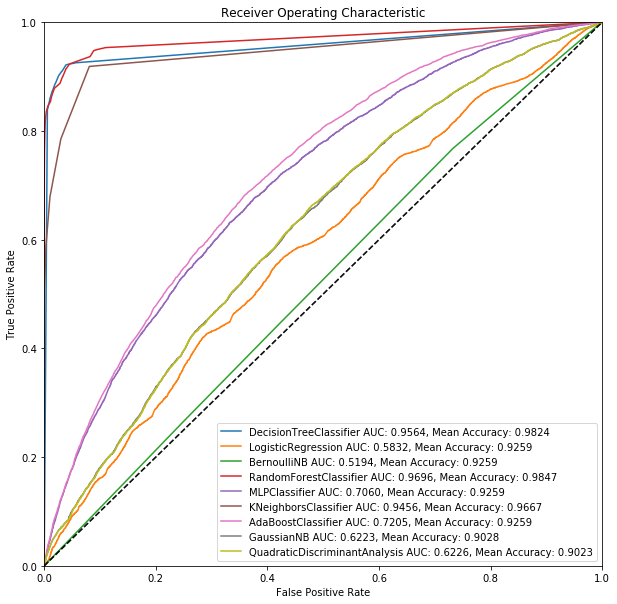

In [29]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (10,10))
for i, model in enumerate(classifiers_fit):
    predict = model.predict_proba(Xte)
    fpr, tpr, thres = roc_curve(Yte, predict[:,1])
    auc = skl.metrics.auc(fpr, tpr)
    acc = model.score(Xte,Yte)
    plt.plot(fpr, tpr, label=(classifier_labels[i] + ' AUC: {:2.4f}, Mean Accuracy: {:2.4f}'.format(auc, acc)))

plt.plot([[0,0],[1,1]], 'k--', label='', alpha=.75)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()